"Lethality Fitting"
-----------------------
This is a script by Elden to attempt to classify lethality of proteins (as defined by the <it>essential protein</it> list) by their degree, SC, etc.

In [6]:
"""Imports and arguments"""

import csv

import networkx as nx

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import network_utilities as nu
import random
import networkx.algorithms.community as nx_comm
import tensorflow as tf

# some basic settings for plotting figures
%matplotlib inline 
font = {'family' : 'serif',
        'weight' : 'light',
        'size'   : 20}

plt.rc('font', **font)

extra_outputs = False;

In [77]:
"""Loading data"""

# This is the variable that will store the protein names. 
ess_list = []; 

with open('essential_proteins.csv', newline='') as ess_file:
    reader = csv.reader(ess_file)
    ess_data = list(reader)

for i in range(len(ess_data)):
    ess_list.append(ess_data[i][1])
    
# Read in the string-db for Yeast
G0 = nx.read_weighted_edgelist("./yeast_protein_edgelist_trimmed.txt",comments="#",nodetype=str)

# For interest, plot the distribution of confidence scores
if (extra_outputs):
    plt.figure(figsize=(6,6));
    full_edges = G0.edges()
    these_weights = [G0[u][v]['weight'] for u,v in full_edges]

    plt.hist(these_weights, bins=40);
    plt.title("Confidence score distribution")
    plt.xlabel("Confidence score")
    plt.ylabel("# Edges")
    plt.show();
    
# delete those edges with a combined score of <= threshold_score (small confidence)
threshold_score = 700;
for edge in G0.edges: 
    weight = list(G0.get_edge_data(edge[0],edge[1]).values())
    if(weight[0] <= threshold_score):
        G0.remove_edge(edge[0],edge[1])
        
# Take only the largest connected subgraph
largest_cc = max(nx.connected_components(G0),key=len)
G = G0.subgraph(largest_cc);
print(G)

Graph with 5932 nodes and 119977 edges


In [78]:
# Let's actually work on a smaller network, for speed:
subset_fraction = 1;
subset_number = int(np.floor(len(list(G.nodes))*subset_fraction))

subset_nodes = random.sample(list(G.nodes), subset_number)

print(subset_nodes)

subset_network = nu.cutdown_network(G,subset_nodes)
#nu.my_draw(subset_network)

['YAL016W', 'YNR031C', 'YHR082C', 'YFL025C', 'YLR126C', 'YDR541C', 'YIL017C', 'YDR066C', 'YNL274C', 'YJR092W', 'YNL294C', 'YDR379W', 'YLR371W', 'YDR509W', 'YPL235W', 'YDR456W', 'YDR461W', 'YER073W', 'YBR047W', 'YJL041W', 'YMR255W', 'YBR115C', 'YOR171C', 'YLR125W', 'YIL165C', 'YOL128C', 'YLR151C', 'YMR253C', 'YJL029C', 'YBR233W-A', 'YLR009W', 'YNL209W', 'YAL040C', 'YJL178C', 'YAR003W', 'YDR464W', 'YDR241W', 'YJL039C', 'YCR106W', 'YGR014W', 'YOR003W', 'YDR086C', 'YMR156C', 'YPR139C', 'YCL026C-A', 'YMR240C', 'YER016W', 'YPL089C', 'YJL204C', 'YOR201C', 'YPR140W', 'YBR290W', 'YLR141W', 'YER095W', 'YLR091W', 'YNL058C', 'YLR054C', 'YBR237W', 'YOR115C', 'YEL060C', 'YER184C', 'YGL237C', 'YCR018C-A', 'YPR011C', 'YAL035W', 'YJL081C', 'YHR183W', 'YJL069C', 'YLR178C', 'YKL059C', 'YJR010W', 'YJL006C', 'Q0085', 'YGR037C', 'YOL067C', 'YJL207C', 'YOR246C', 'YGR177C', 'YNL305C', 'YHR148W', 'YFL017W-A', 'YBR010W', 'YBL107C', 'YKL143W', 'YNL067W', 'YPL193W', 'YBL086C', 'YDR184C', 'YFL053W', 'YDL179W', 'YH

In [79]:
# Let's generate the binary array to color nodes:

ess_selector = nu.value_lambda_result(
    list(subset_network.nodes), # values
    [lambda p: p in ess_list], # tests
    [1], # results
    default = 0); 

ess_colors = ['red' if k == 1 else 'blue' for k in ess_selector]

# and some random names:
rand_name_period = 100

name_list_full = list(G.nodes) 
name_list_cutdown = [name_list_full[n] if n % rand_name_period == 0 else None for n in range(len(name_list_full))]
just_one_name = [name if name == "YPT232W" else None for name in name_list_full]

Let's look at the distribution of nodes w.r.t. a few properties, colored by essentiality, to see if we can see any trends.

Each cell runs an individual measure for processing efficiency, then the chosen two are run by the last cell. The cells are roughly ordered in order of runtime.

In [5]:
degrees_labeled = list(subset_network.degree);
degrees = [d[1] for d in degrees_labeled] # stripping away the labels

In [80]:
eigen_centrality = list(nx.eigenvector_centrality(subset_network).values())

In [81]:
subgraph_centrality = list(nx.subgraph_centrality(subset_network).values())

In [8]:
# Veeeery long. Uncomment at your peril. Of course we would prefer to avoid computationally expensive measure! 
#est_samples = 2; 

# we can limit the number of nodes it checks to trade accuracy for speed
# Buuuut even with this parameter this is too long

betweenness_centrality = list(nx.betweenness_centrality(subset_network).values())

In [9]:
# Veeeery long. Uncomment at your peril. Of course we would prefer to avoid computationally expensive measure! 
closeness_centrality = list(nx.closeness_centrality(subset_network).values())

In [10]:
# Cross-clique connectivity is NP-complete with exp running time, so we cannot practically use it
# 

In [128]:
# Let's save the measures data for later:
f = open("network_measures.csv", "w")
csv_names = list(subset_network.nodes)

f.write("# Name, Essential?, Degree, Eigenvector Centrality, Betweenness Centrality, Closeness centrality\n")
for l in range(len(degrees)):
    f.write(str(csv_names[l]) + ", " + str(csv_names[l] in ess_list) + ", " + str(degrees[l]) + ", " + str(eigen_centrality[l]) + ", " 
            + str(betweenness_centrality[l]) + ", " + str(closeness_centrality[l]) + "\n")
f.close()

In [45]:
# Import from these values

# [degrees, eigen_centrality, betweenness_centrality, closeness_centrality]

# IF IMPORTING FROM THE SAVED VALUES, START FROM HERE
importing_from_file = True
if (importing_from_file):
    with open('network_measures.csv', newline='') as network_measures_file:
        reader = csv.reader(network_measures_file)
        measure_data = list(reader)

    imported_names = []
    imported_ess = []
    degrees = []
    eigen_centrality = []
    betweenness_centrality= []
    closeness_centrality= []

    for line in measure_data[1:]:
        imported_names.append(line[0])
        imported_ess.append(line[1][1:])
        degrees.append(float(line[2]))
        eigen_centrality.append(float(line[3]))
        betweenness_centrality.append(float(line[4]))
        closeness_centrality.append(float(line[5]))
        
    ess_colors = ['red' if k == 'True' else 'blue' for k in imported_ess]

['blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'red',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'red',
 'blue',
 'red',
 'blue',
 'blue',
 'red',
 'blue',
 'blue',
 'red',
 'red',
 'blue',
 'red',
 'blue',
 'red',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'red',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'red',
 'blue',
 'blue',
 'blue',
 'blue',
 'red',
 'blue',
 'blue',
 'blue',
 'blue',
 'red',
 'blue',
 'blue',
 'blue',
 'blue',
 'red',
 'blue',
 'blue',
 'blue',
 'red',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'red',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'red',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'red',
 'red',
 'red',
 'blue',
 'blue',
 'blue',
 'blue',
 'red',
 'red',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'bl

Now we plot the desired pairs:

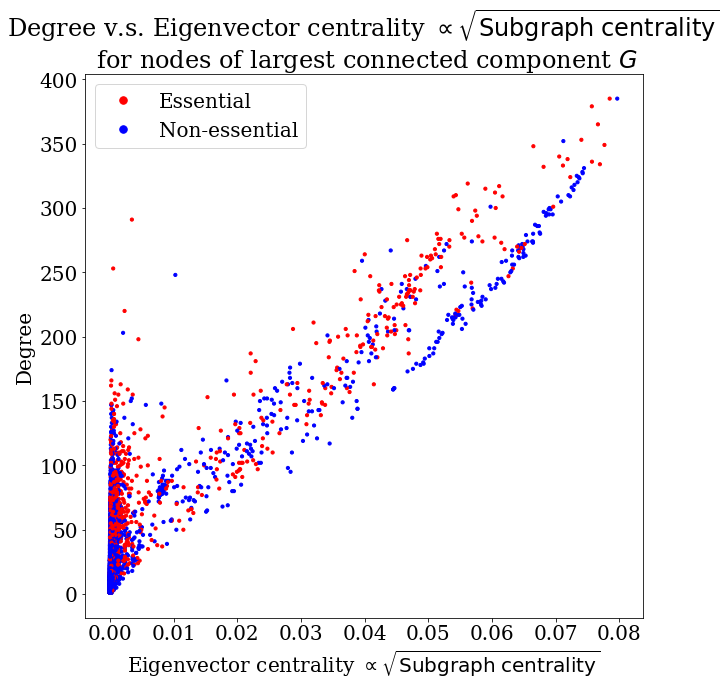

In [46]:
# Compose a custom legend to label the colors:
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='.', color='red', label='Essential',
                          markerfacecolor='red', markersize=15, linewidth=0),
                   Line2D([0], [0], marker='.', color='blue', label='Non-essential',
                          markerfacecolor='blue', markersize=15, linewidth=0)]
def ess_legend():
    plt.legend(handles=legend_elements, loc='best')
# degree vs eigen


plt.figure(figsize=(10,10))
plt.tight_layout()
plt.scatter(eigen_centrality, degrees, c = ess_colors, s=10)
plt.title("Degree v.s. Eigenvector centrality $\propto\sqrt{\mathrm{Subgraph\;centrality}}$ \n for nodes of largest connected component $G$")
plt.xlabel("Eigenvector centrality $\propto \sqrt{\mathrm{Subgraph\;centrality}}$");
plt.ylabel("Degree")

ess_legend()


# Names:

# To zoom in:
naming_nodes = False
if (naming_nodes):
    Zooming_in = False
    if (Zooming_in):
        x_min = 0
        x_max = 0.001
        y_min = 0 
        y_max = 50
        plt.xlim([x_min,x_max])
        plt.ylim([y_min,y_max])
        for i in range(len(eigen_centrality)):
            if (name_list_cutdown[i] is not None):
                if (eigen_centrality[i] > x_min and eigen_centrality[i] < x_max
                   and degrees[i] > y_min and degrees[i] < y_max):
                    plt.text(eigen_centrality[i], degrees[i],name_list_cutdown[i], fontsize=10)
    else:
        for i in range(len(eigen_centrality)):
            if (name_list_cutdown[i] is not None):
                plt.text(eigen_centrality[i], degrees[i],name_list_cutdown[i], fontsize=10)

just_one = False
if (just_one):
    for i in range(len(eigen_centrality)):
        if (just_one_name[i] is not None):
            plt.text(eigen_centrality[i], degrees[i],just_one_name[i], fontsize=10)
        
plt.savefig("HRY Diagram.pdf")
plt.show()

### Observations

We see that subgraph and eigenvector centrality almost exactly correlate:

In [47]:
eigen_centrality_sq  = [c**2 for c in eigen_centrality]

plt.figure(figsize=(10,10))
plt.scatter(subgraph_centrality,eigen_centrality_sq, c = ess_colors)
plt.title("Eigenvector centrality squared vs. subgraph centrality for\nlargest connected component $G$")
plt.xlabel("Subgraph centrality");
plt.ylabel("Eigenvector centrality squared")

corr_coeff = np.corrcoef(subgraph_centrality,eigen_centrality_sq)[1,0];

fit_gradient = (max(eigen_centrality_sq)-min(eigen_centrality_sq))/(max(subgraph_centrality)-min(subgraph_centrality)) # approx'! 

plt.text(3.7e88,0.0018, "r = "+ str(corr_coeff) +"\n\n" + r"m $\approx$"+str(fit_gradient),rotation=45)

plt.show()

NameError: name 'subgraph_centrality' is not defined

<Figure size 720x720 with 0 Axes>

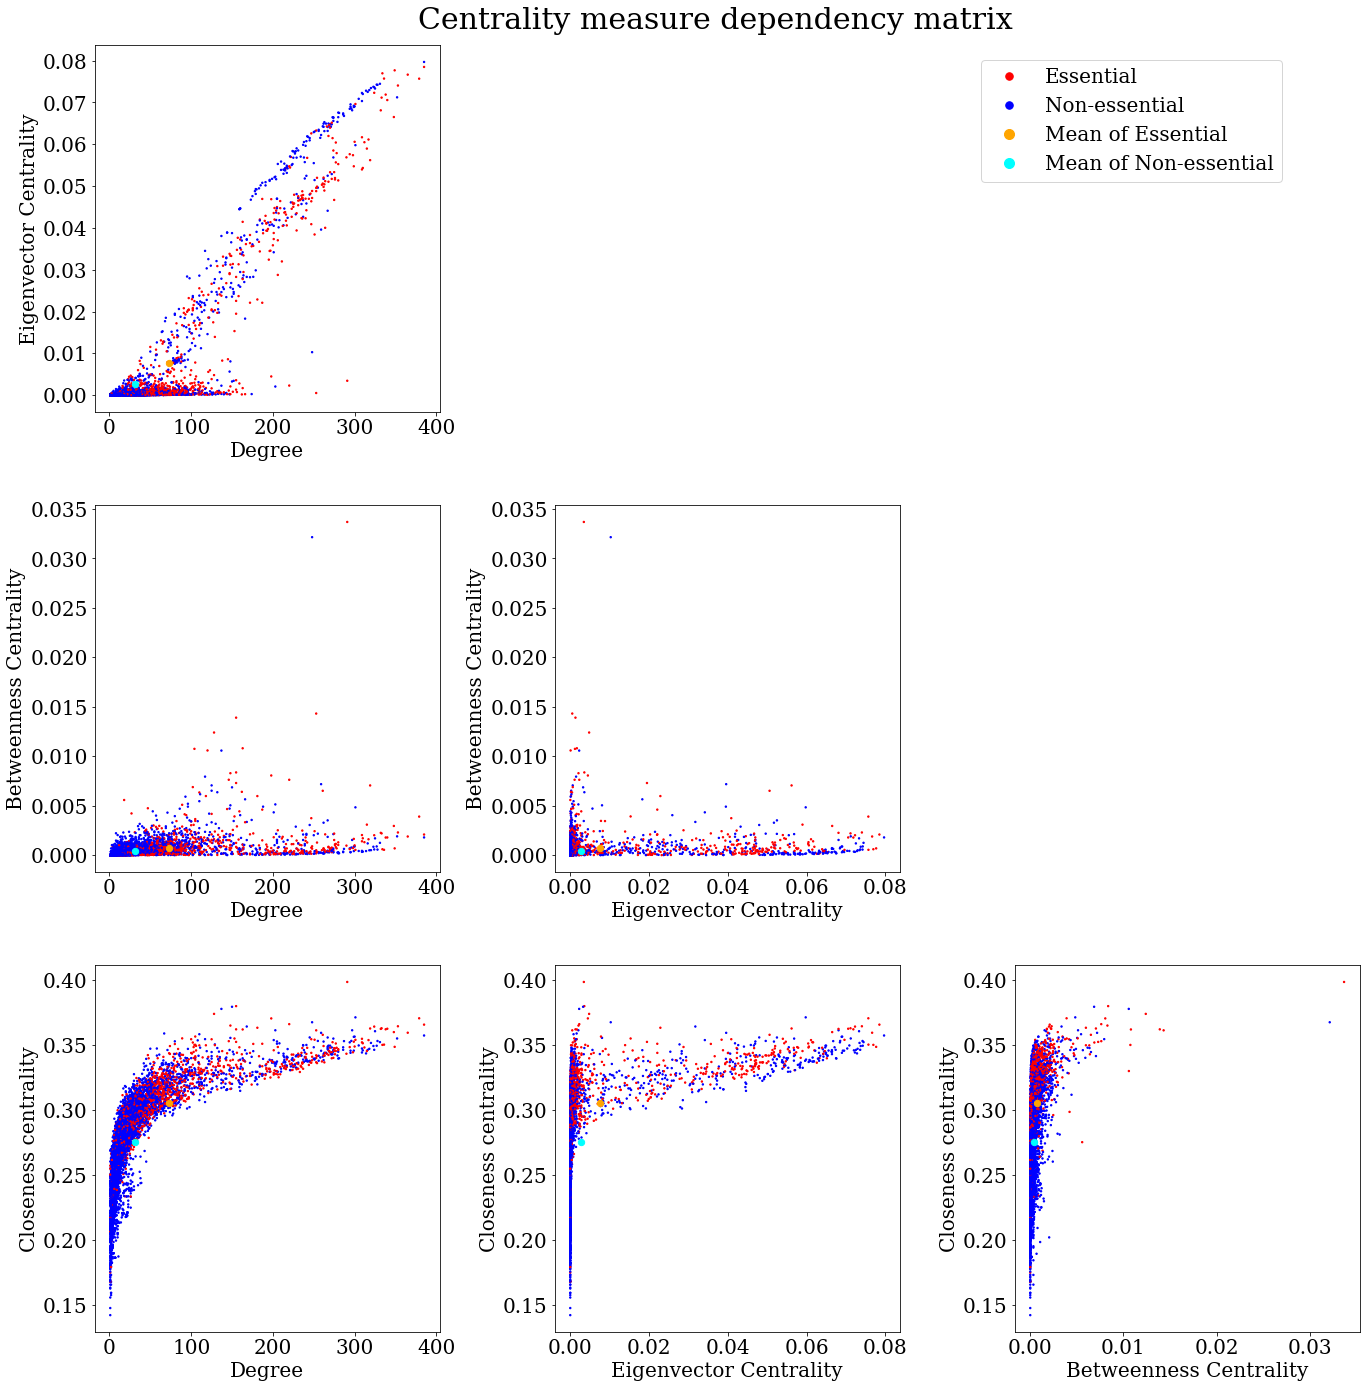

In [76]:
# Let's be more systematic with out correlation plots
# We list our independent measures:
measures = [degrees, eigen_centrality, betweenness_centrality, closeness_centrality]
measure_names = ["Degree", "Eigenvector Centrality", "Betweenness Centrality", "Closeness centrality"]

n_measures = len(measures)


# Let's calculate the mean or each measure for ess vs. non-ess
ess_measure_means = np.zeros(n_measures)
noness_measure_means = np.zeros(n_measures)
n_ess = 0;
n_noness = 0;
for i in range(len(degrees)):
    if (ess_colors[i] == 'red'):
        n_ess += 1
        for m in range(n_measures):
            ess_measure_means[m] += measures[m][i]
    else:
        n_noness += 1
        for m in range(n_measures):
            noness_measure_means[m] += measures[m][i]

ess_measure_means = [val/n_ess for val in ess_measure_means] # normalise the mean properly
noness_measure_means = [val/n_noness for val in noness_measure_means]
            
fig, axs = plt.subplots(n_measures-1, n_measures-1,figsize=(20,20))
fig.tight_layout(pad=3.0)
fig.suptitle('Centrality measure dependency matrix', fontsize=30)


    
legend_elements_with_means = [Line2D([0], [0], marker='.', color='red', label='Essential',
                          markerfacecolor='red', markersize=15, linewidth=0),
                   Line2D([0], [0], marker='.', color='blue', label='Non-essential',
                          markerfacecolor='blue', markersize=15, linewidth=0),
                   Line2D([0], [0], marker='.', color='orange', label='Mean of Essential',
                          markerfacecolor='orange', markersize=20, linewidth=0),
                   Line2D([0], [0], marker='.', color='cyan', label='Mean of Non-essential',
                          markerfacecolor='cyan', markersize=20, linewidth=0)]

fig.legend(handles=legend_elements_with_means,loc = 'upper right', bbox_to_anchor=(0.9, 0.95))
    
for ix_ax in range(n_measures):
    for iy_ax in range(ix_ax+1,n_measures):
        axs[iy_ax-1,ix_ax].scatter(measures[ix_ax], measures[iy_ax], c = ess_colors, s=2) # 
        #axs[ix_ax,iy_ax].set_title(measure_names[iy_ax] + " v.s. "+ measure_names[ix_ax]+"for nodes of largest connected component $G$")
        axs[iy_ax-1,ix_ax].set(xlabel=measure_names[ix_ax], ylabel=measure_names[iy_ax])
        #axs[iy_ax-1,ix_ax].text(xlabel=measure_names[ix_ax], ylabel=measure_names[iy_ax])
        
        if (False): # To print names
            names = list(G.nodes)
            for i in range(len(names)):
                axs[iy_ax-1,ix_ax].text(measures[ix_ax][i], measures[iy_ax][i], names[i], fontsize=10)
                
        if (True): # To plot means
            axs[iy_ax-1,ix_ax].scatter(ess_measure_means[ix_ax], ess_measure_means[iy_ax], marker = "o",c = "orange", s = 40)
            axs[iy_ax-1,ix_ax].scatter(noness_measure_means[ix_ax], noness_measure_means[iy_ax], marker = "o",c = "cyan", s = 40)


# Hide the symmetric plots
for i in range(1,n_measures-1):
    for j in range(0,i):
            axs[j,i].axis('off')


plt.savefig("Measure Dependency Matrix.pdf")

        #ess_legend()

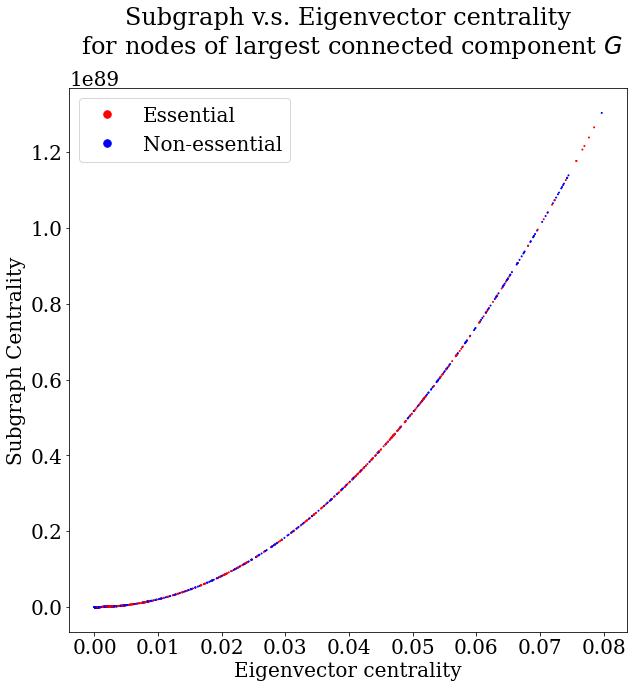

In [85]:
plt.figure(figsize=(10,10))
plt.scatter(eigen_centrality, subgraph_centrality, c = ess_colors, s=1)
plt.title("Subgraph v.s. Eigenvector centrality\n for nodes of largest connected component $G$\n")
plt.xlabel("Eigenvector centrality");
plt.ylabel("Subgraph Centrality")

ess_legend()

In [58]:
np.mean(measures[3])

0.28150715284119854

In [60]:
len((degrees))

5932